<a href="https://colab.research.google.com/github/Danna-Bustacara/-Dimplomado_Ciencia_Datos/blob/main/Desempleo_Redes_neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.12.0
Pandas Version: 1.5.3
Numpy Version: 1.22.4
System Version: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
Desempleo=Desempleo2=pd.read_excel("/content/drive/Shareddrives/Eduardo1/tasa_desempleo.xlsx", names=['Fecha', 'ocupación','desempleo'])
Desempleo=Desempleo2 = Desempleo2.drop('ocupación', axis=1)
Desempleo['Fecha']=pd.to_datetime(Desempleo['Fecha'])
Desempleo=Desempleo.set_index('Fecha')
print(type(Desempleo))

Desempleo_ts=Desempleo['desempleo']
print(type(Desempleo_ts))
Desempleo_ts.index.freq='MS'

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [7]:
df=Desempleo

In [8]:
features_considered = ['desempleo']

array([<Axes: xlabel='Fecha'>], dtype=object)

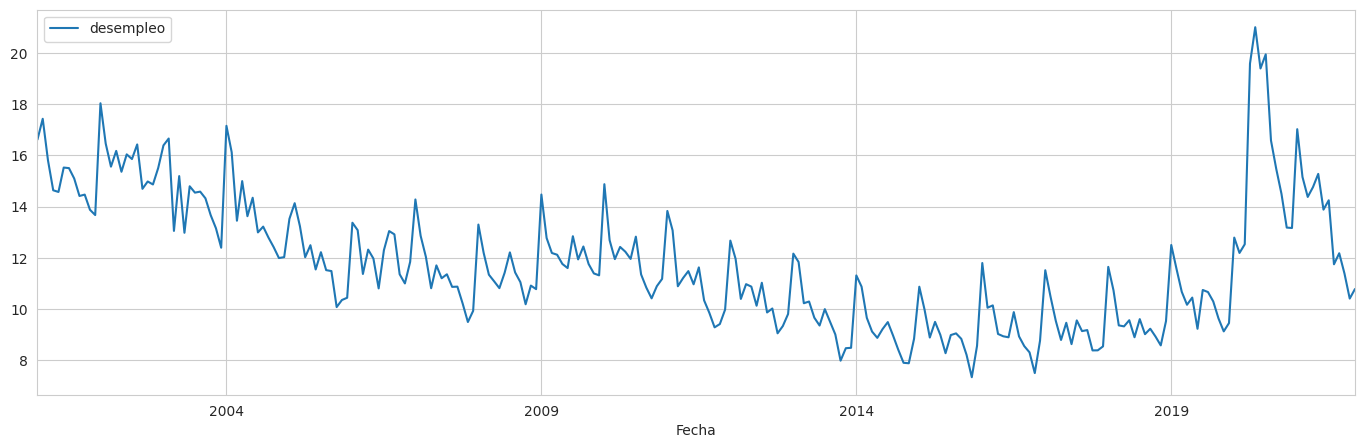

In [60]:
features.plot(subplots=True)

In [61]:
column_indices = {name: i for i, name in enumerate(features.columns)}

n = len(features)
train_df = features[0:176]
val_df = features[176:214]
test_df = features[214:]

num_features = features.shape[0]

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Modelamiento

In [62]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [14]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [15]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=48,)  ####  tamaño del lote

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [16]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [21]:
def plot(self, model=None, plot_col='desempleo', max_subplots=2):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [22]:
MAX_EPOCHS = 50 ### numero de epocas

def compile_and_fit(model, window, patience=0):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Configuración de la ventana

In [23]:
## input_width=12  anual

single_step_window = WindowGenerator(
    input_width=12, label_width=1, shift=6,
    label_columns=['desempleo'])# La variable a predecir
single_step_window

Total window size: 18
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [17]
Label column name(s): ['desempleo']

In [24]:
dataset_train_len = len(list(single_step_window.train.unbatch().map(lambda x, y: (x, y))))
dataset_val_len = len(list(single_step_window.val.unbatch().map(lambda x, y: (x, y))))
dataset_test_len = len(list(single_step_window.test.unbatch().map(lambda x, y: (x, y))))

Tenemos las observaciones para los conjuntos de datos

In [25]:
print("longitud datos de entrenamiento:",dataset_train_len)
print("longitud datos de validación:",dataset_val_len)
print("longitud datos de prueba:",dataset_test_len)

longitud datos de entrenamiento: 159
longitud datos de validación: 21
longitud datos de prueba: 21


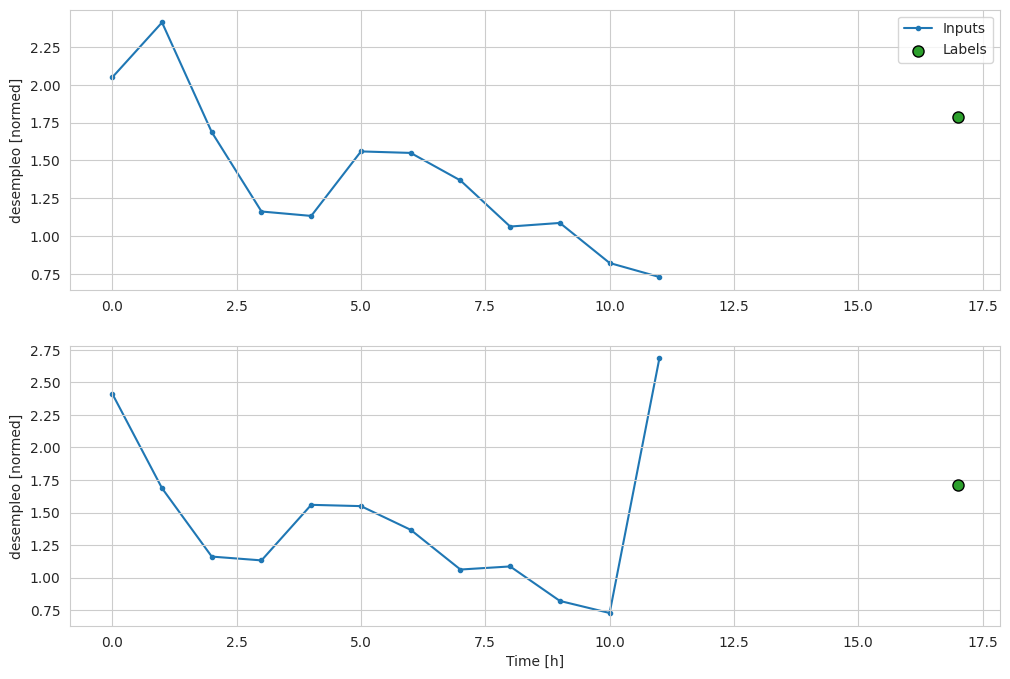

In [26]:
single_step_window.plot()

Modelo denso con RamdonSearch

1. Tunning

In [27]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.8 MB/s eta 0:00:00


In [28]:
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers

In [29]:
for batch in single_step_window.train.take(1):
    inputs_train,targets_train = batch


print("Input shape:", inputs_train.numpy().shape)
print("Target shape:", targets_train.numpy().shape)

Input shape: (48, 12, 1)
Target shape: (48, 1, 1)


In [30]:
for batch in single_step_window.val.take(1):
    inputs_val,targets_val = batch

print("Input shape:", inputs_val.numpy().shape)
print("Target shape:", targets_val.numpy().shape)

Input shape: (21, 12, 1)
Target shape: (21, 1, 1)


Para entrenamiento

In [31]:
input_dataset_train = single_step_window.train.map(lambda x,y: x)
target_dataset_train = single_step_window.train.map(lambda x,y: y)

Para validación

In [32]:
input_dataset_val = single_step_window.val.map(lambda x,y: x)
target_dataset_val = single_step_window.val.map(lambda x,y: y)

Para prueba

In [33]:
input_dataset_test = single_step_window.test.map(lambda x,y: x)
target_dataset_test = single_step_window.test.map(lambda x,y: y)

In [34]:
single_step_window.test.map(lambda x,y: y)

<_MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>

Función

In [35]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int("num_units", min_value=32, max_value=564, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"])))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=128, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="linear"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=["mean_squared_error"]
    )
    return model


build_model(kt.HyperParameters())

In [36]:
tuner_RandomSearch_mlp = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=4,
    executions_per_trial=1,
    overwrite=True,
    directory="dirsalida",
    project_name="helloworld",
)

In [37]:
tuner_RandomSearch_mlp.search_space_summary()

Search space summary
Default search space size: 6
num_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 564, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [38]:
stop_early=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=1)

In [39]:
tuner_RandomSearch_mlp.search((single_step_window.train), epochs=20, validation_data=(single_step_window.val),callbacks=[stop_early])

Trial 4 Complete [00h 00m 03s]
val_loss: 0.33417975902557373

Best val_loss So Far: 0.27353280782699585
Total elapsed time: 00h 00m 37s


In [40]:
tuner_RandomSearch_mlp.results_summary()

Results summary
Results in dirsalida/helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
num_units: 32
activation: tanh
num_layers: 1
units_0: 32
dropout: True
lr: 0.003533627817437416
Score: 0.27353280782699585

Trial 2 summary
Hyperparameters:
num_units: 288
activation: relu
num_layers: 1
units_0: 128
dropout: True
lr: 0.0027347243931217773
units_1: 64
units_2: 96
Score: 0.2778223752975464

Trial 3 summary
Hyperparameters:
num_units: 192
activation: relu
num_layers: 1
units_0: 96
dropout: False
lr: 0.007087792290208363
units_1: 96
units_2: 96
Score: 0.33417975902557373

Trial 1 summary
Hyperparameters:
num_units: 480
activation: relu
num_layers: 3
units_0: 128
dropout: True
lr: 0.00039378484426119724
units_1: 32
units_2: 32
Score: 0.40937110781669617


Evaluar el modelo con datos de entrenamiento + validación

In [41]:
train_plus_val=single_step_window.train.concatenate(single_step_window.val)###verificar que en efecto

Se ajusta el mejor modelo

In [42]:
# Get the top 2 hyperparameters.
best_hps_mlp = tuner_RandomSearch_mlp.get_best_hyperparameters(2)
# Build the model with the best hp.
callback=tf.keras.callbacks.EarlyStopping(monitor="loss",patience=0)
model_mlp = build_model(best_hps_mlp[1])


In [43]:
# Fit with the entire dataset.
model_mlp.fit(train_plus_val, epochs=20,callbacks=[callback])

Epoch 1/20
5/5 [==============================] - 1s 18ms/step - loss: 0.6402 - mean_squared_error: 0.6402
Epoch 2/20
5/5 [==============================] - 0s 19ms/step - loss: 0.4114 - mean_squared_error: 0.4114
Epoch 3/20
5/5 [==============================] - 0s 17ms/step - loss: 0.4450 - mean_squared_error: 0.4450


Modelo escogido con los mejores hiper

In [44]:
model_mlp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12, 288)           576       
                                                                 
 dense_4 (Dense)             (None, 12, 128)           36992     
                                                                 
 dropout (Dropout)           (None, 12, 128)           0         
                                                                 
 dense_5 (Dense)             (None, 12, 1)             129       
                                                                 
Total params: 37,697
Trainable params: 37,697
Non-trainable params: 0
_________________________________________________________________


Evaluación del modelo para test

In [45]:
model_mlp.evaluate(single_step_window.test, verbose=1)

1/1 [==============================] - 0s 252ms/step - loss: 5.9777 - mean_squared_error: 5.9777


[5.977691173553467, 5.977691173553467]

Predicción del modelo

In [46]:
Test_std=model_mlp.predict(single_step_window.test).flatten()

1/1 [==============================] - 0s 264ms/step


Pasar a la escala orginal

In [47]:
prediction_test=(model_mlp.predict(test_df, verbose=1)*train_std['desempleo']+train_mean['desempleo'])


2/2 [==============================] - 0s 7ms/step


In [48]:
print(prediction_test.shape)
print(prediction_test)


(38, 1, 1)
[[[ 8.531507 ]]

 [[ 9.379405 ]]

 [[11.933267 ]]

 [[11.150948 ]]

 [[10.394012 ]]

 [[ 9.9460945]]

 [[10.1946125]]

 [[ 9.1106825]]

 [[10.456157 ]]

 [[10.384323 ]]

 [[10.061159 ]]

 [[ 9.470757 ]]

 [[ 9.020051 ]]

 [[ 9.309913 ]]

 [[12.154429 ]]

 [[11.583613 ]]

 [[11.957371 ]]

 [[16.20565  ]]

 [[17.032536 ]]

 [[16.093792 ]]

 [[16.414715 ]]

 [[14.451784 ]]

 [[13.798645 ]]

 [[13.212233 ]]

 [[12.411748 ]]

 [[12.401833 ]]

 [[14.70974  ]]

 [[13.609562 ]]

 [[13.140984 ]]

 [[13.371513 ]]

 [[13.681097 ]]

 [[12.841749 ]]

 [[13.062317 ]]

 [[11.284301 ]]

 [[11.575498 ]]

 [[11.004824 ]]

 [[10.160737 ]]

 [[10.488157 ]]]


In [49]:
i=1
for batch in target_dataset_test.take(45): ## numero de lotes en train
    if i==1:
        targets_test = batch.numpy()
    elif i>1:
        targets_test_aux = batch.numpy()
        targets_test=np.append(targets_test,targets_test_aux)
    i=i+1


In [50]:

true_series=test_df*train_std['desempleo']+train_mean['desempleo']
print(true_series.shape)

(38, 1)


Error cuadratico medio

In [51]:
errors_squared=tf.keras.metrics.mean_squared_error(true_series, prediction_test).numpy()
print("RECM:",errors_squared.mean()**0.5)

RECM: 4.031395724715922


Errores de predicción para el modelo

In [52]:
error_prediction_test=true_series["desempleo"]-prediction_test.reshape(-1,)

In [53]:
error_prediction_test

Fecha
2018-11-01    0.042623
2018-12-01    0.145660
2019-01-01    0.565570
2019-02-01    0.414182
2019-03-01    0.275406
2019-04-01    0.216579
2019-05-01    0.248443
2019-06-01    0.112832
2019-07-01    0.284803
2019-08-01    0.273987
2019-09-01    0.231189
2019-10-01    0.156880
2019-11-01    0.101719
2019-12-01    0.137203
2020-01-01    0.634594
2020-02-01    0.604283
2020-03-01    0.570001
2020-04-01    3.387364
2020-05-01    3.980923
2020-06-01    3.307182
2020-07-01    3.537442
2020-08-01    2.133637
2020-09-01    1.677866
2020-10-01    1.284258
2020-11-01    0.768063
2020-12-01    0.762133
2021-01-01    2.317394
2021-02-01    1.549097
2021-03-01    1.236978
2021-04-01    1.389954
2021-05-01    1.597814
2021-06-01    1.039934
2021-07-01    1.184776
2021-08-01    0.460435
2021-09-01    0.600810
2021-10-01    0.378787
2021-11-01    0.244064
2021-12-01    0.289736
Freq: MS, Name: desempleo, dtype: float64

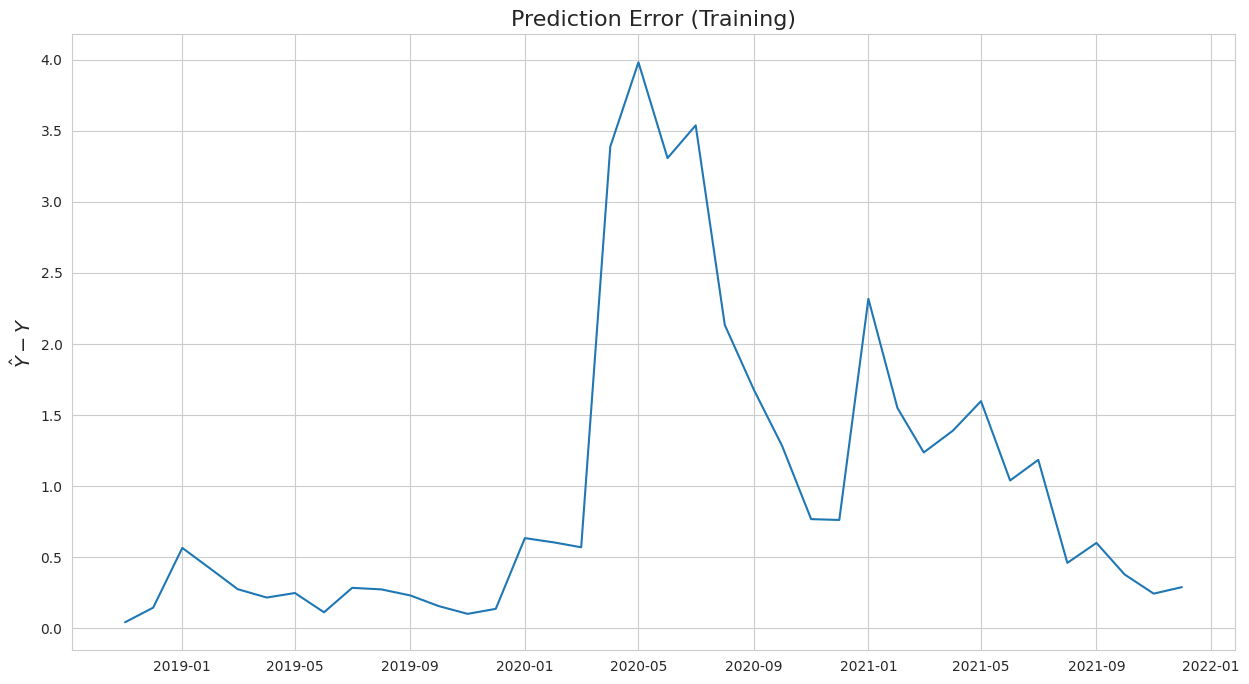

In [54]:
fig = plt.figure(figsize=(15,8))
plt.plot(error_prediction_test)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.title('Prediction Error (Training)', fontsize=16);

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


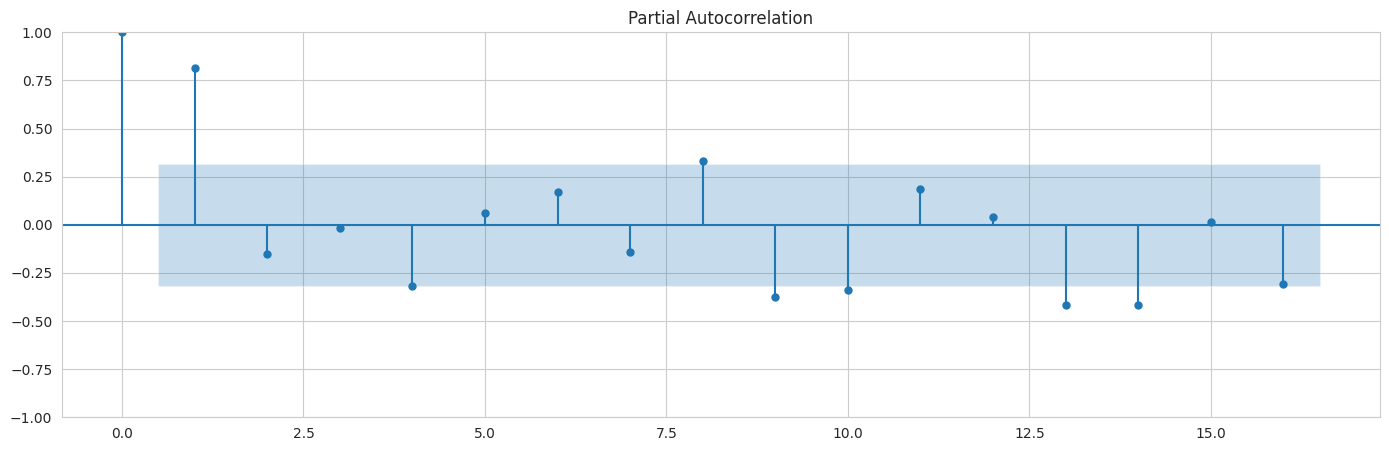

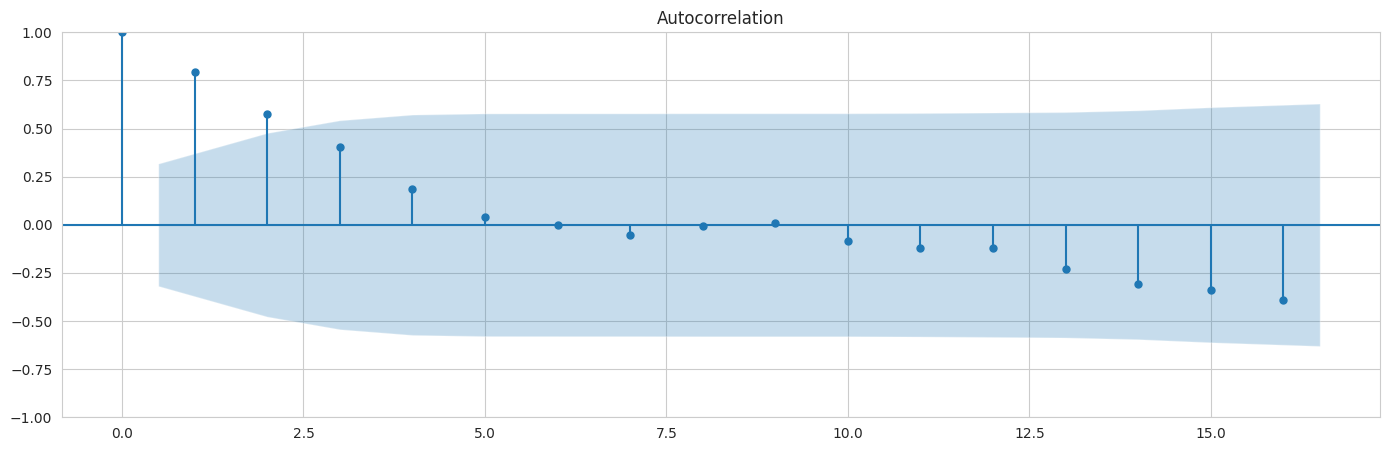

In [55]:
graficapacf=plot_pacf(error_prediction_test)
graficaacf=plot_acf(error_prediction_test)

Grafica para el conjunto de prueba

In [56]:
test_index=test_df.index[:38]
test_index.values

array(['2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000', '2019-02-01T00:00:00.000000000',
       '2019-03-01T00:00:00.000000000', '2019-04-01T00:00:00.000000000',
       '2019-05-01T00:00:00.000000000', '2019-06-01T00:00:00.000000000',
       '2019-07-01T00:00:00.000000000', '2019-08-01T00:00:00.000000000',
       '2019-09-01T00:00:00.000000000', '2019-10-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-12-01T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000', '2020-02-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-04-01T00:00:00.000000000',
       '2020-05-01T00:00:00.000000000', '2020-06-01T00:00:00.000000000',
       '2020-07-01T00:00:00.000000000', '2020-08-01T00:00:00.000000000',
       '2020-09-01T00:00:00.000000000', '2020-10-01T00:00:00.000000000',
       '2020-11-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000',
       '2021-01-01T00:00:00.000000000', '2021-02-01

In [57]:
true_series_final=true_series

In [72]:
prediction_test_final=prediction_test.reshape(-1,)

In [78]:
R = pd.DataFrame({'Columna1': prediction_test_final, 'Fecha': true_series_final.index})

In [100]:
Prediccion=R.set_index('Fecha')

Text(0, 0.5, 'Y y $\\hat{Y}$ en conjunto de prueba')

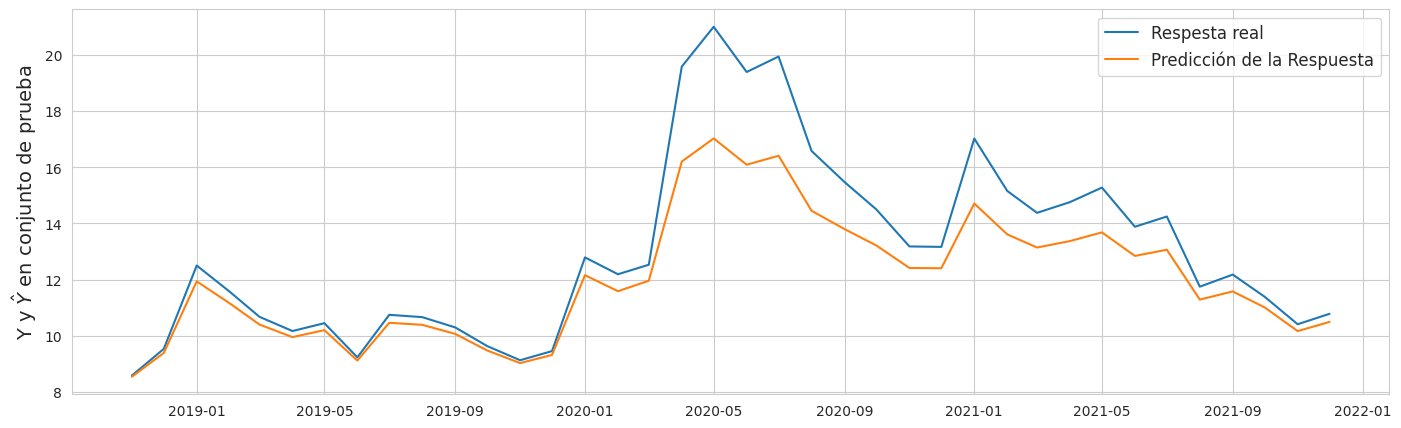

In [99]:
plt.plot(true_series)
plt.plot(Prediccion)
plt.legend(['Respesta real','Predicción de la Respuesta'],loc="best", fontsize=12)
plt.ylabel('Y y $\hat{Y}$ en conjunto de prueba', fontsize=14)

**Residuales**

In [106]:
Prediccion1=np.reshape(Prediccion.values, -1)

In [113]:
Valores=np.reshape(true_series.values, -1)

In [115]:
Residuales=Valores-Prediccion1

<ipython-input-117-161ee7508874>:1: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  plot_acf(Residuales,lags=28, unbiased=False)


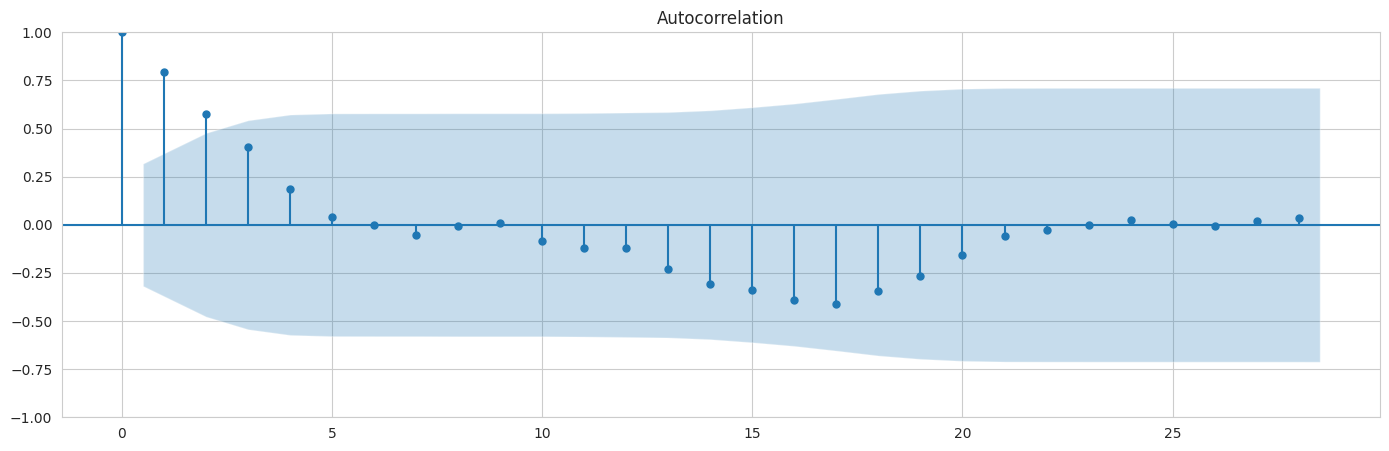

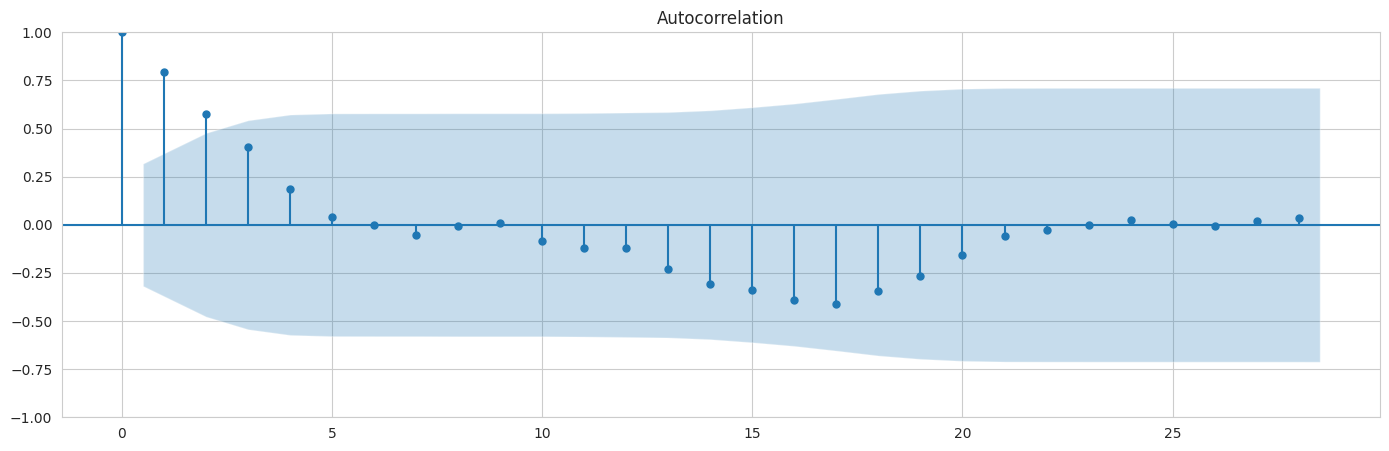

In [117]:
plot_acf(Residuales,lags=28, unbiased=False)

Text(0.5, 0, 'Index')

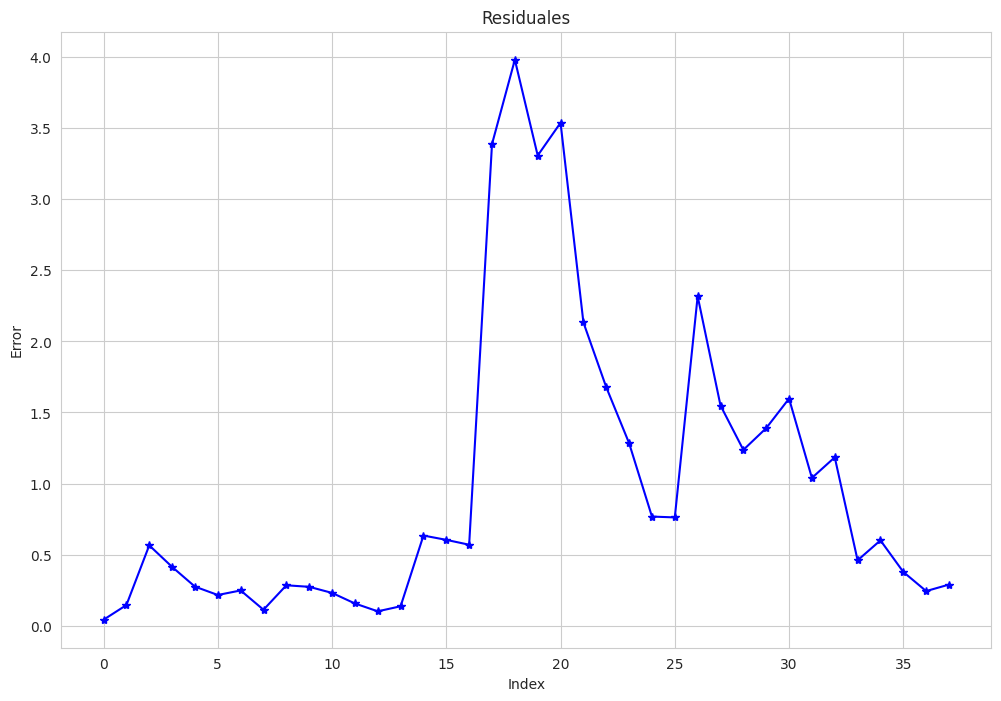

In [119]:
plt.figure(figsize=(12, 8))
plt.plot(range(Residuales.size), Residuales, linestyle='-', marker='*', color='b')
plt.title('Residuales')
plt.ylabel('Error')
plt.xlabel('Index')

**COMPARACIÓN CAPACIDAD PREDICTIVA**

**RECM SARIMA**:7.647692

**RECM REDES NEURONALES**: 4.0313957

**RECM ÁRBOLES DE DECISIÓN**: 1.141773